## Problem Statement
#### In this assignment, you will build a multiclass classification model using a custom convolutional neural network in TensorFlow. 

#### To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


#### The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

### The data set contains the following diseases:

* Actinic keratosis
* Basal cell carcinoma
* Dermatofibroma
* Melanoma
* Nevus
* Pigmented benign keratosis
* Seborrheic keratosis
* Squamous cell carcinoma
* Vascular lesion

## Project Solution Steps:

* Importing all the important libraries
* Data Reading/Data Understanding
* Dataset Creation
* Dataset visualisation
* Model Building & training
* Chose an appropriate data augmentation strategy to resolve underfitting/overfitting
* Model Building & training on the augmented data
* Class distribution
* Handling class imbalances
* Model Building & training on the rectified class imbalance data


### Importing all the important libraries

In [7]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [8]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2365 images of skin cancer types. (2247 and 118 in each train and test respectively)  The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [9]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/AI-ML/CNN_assignment/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/AI-ML/CNN_assignment/Test')

In [10]:
# Delete output folder from previous run.
# import shell utility
import shutil
dir_train = "/content/gdrive/MyDrive/AI-ML/CNN_assignment/Train"
for folder in os.listdir(dir_train):
  output_path = dir_train + '/' + folder + '/output'
  print(output_path)
  if os.path.exists(output_path):
    shutil.rmtree(output_path)

/content/gdrive/MyDrive/AI-ML/CNN_assignment/Train/actinic keratosis/output
/content/gdrive/MyDrive/AI-ML/CNN_assignment/Train/squamous cell carcinoma/output
/content/gdrive/MyDrive/AI-ML/CNN_assignment/Train/vascular lesion/output
/content/gdrive/MyDrive/AI-ML/CNN_assignment/Train/melanoma/output
/content/gdrive/MyDrive/AI-ML/CNN_assignment/Train/seborrheic keratosis/output
/content/gdrive/MyDrive/AI-ML/CNN_assignment/Train/dermatofibroma/output
/content/gdrive/MyDrive/AI-ML/CNN_assignment/Train/pigmented benign keratosis/output
/content/gdrive/MyDrive/AI-ML/CNN_assignment/Train/nevus/output
/content/gdrive/MyDrive/AI-ML/CNN_assignment/Train/basal cell carcinoma/output


In [11]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [12]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [13]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#train_ds = ##todo
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [14]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [15]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

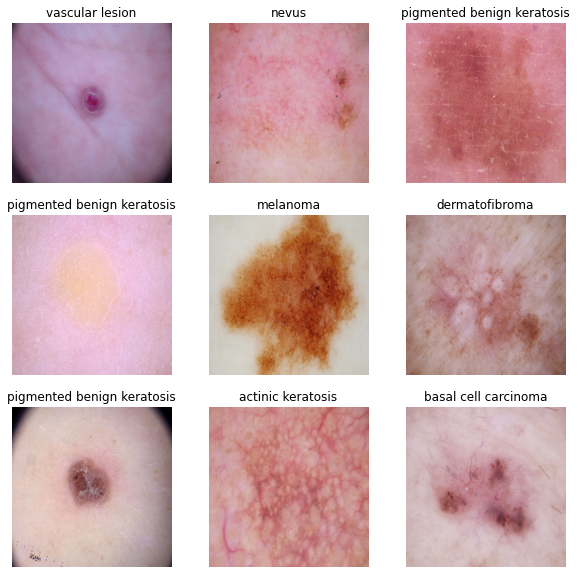

In [16]:
### your code goes here, you can use training or validation data to visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [18]:
### Your code goes here
num_classes = 9
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [19]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [21]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 625s 3s/step - loss: 2.0787 - accuracy: 0.2316 - val_loss: 1.9235 - val_accuracy: 0.2461
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.7379 - accuracy: 0.3839 - val_loss: 1.5347 - val_accuracy: 0.4407
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4695 - accuracy: 0.4877 - val_loss: 1.5003 - val_accuracy: 0.4922
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4028 - accuracy: 0.4989 - val_loss: 1.5284 - val_accuracy: 0.4899
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.2995 - accuracy: 0.5374 - val_loss: 1.3807 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.1834 - accuracy: 0.5759 - val_loss: 1.4067 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.1736 - accuracy: 0.5876 - val_loss: 1.4032 - val_accuracy: 0.5347
Epoch 8/20
56

### Visualizing training results

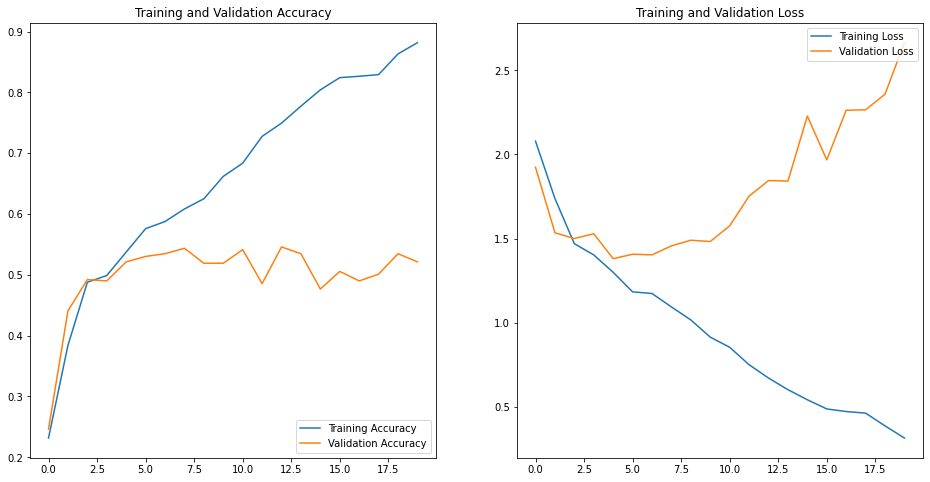

In [22]:
def analyze_results(epochs, acc, val_acc, loss, val_loss):
  epochs_range = range(epochs)
  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

analyze_results(epochs, history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit


In [23]:
accuracy_df = pd.DataFrame(data=[{"Type":"Model - First","Epochs":epochs,"Loss":history.history['loss'][-1],"Accuracy":history.history['accuracy'][-1],
                                  "Validation Loss":history.history['val_loss'][-1],"Validation Accuracy":history.history['val_accuracy'][-1]}])
accuracy_df

,Type,Epochs,Loss,Accuracy,Validation Loss,Validation Accuracy
0,Model - First,20,0.315078,0.881696,2.663557,0.521253


### Write your findings here

## Observations:
* The validation loss as observed is very high.
* This could also be indicative of some Overfit in the model.
* Big difference observed between Training and Validation accuracy.
* We could add some Dropout layers and remove the BatchNormalization layers.
* By adding a few more layers, we could improve the accuracy by trying to extract more features.





## Checking the distribution of classes in the data.

In [24]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [25]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

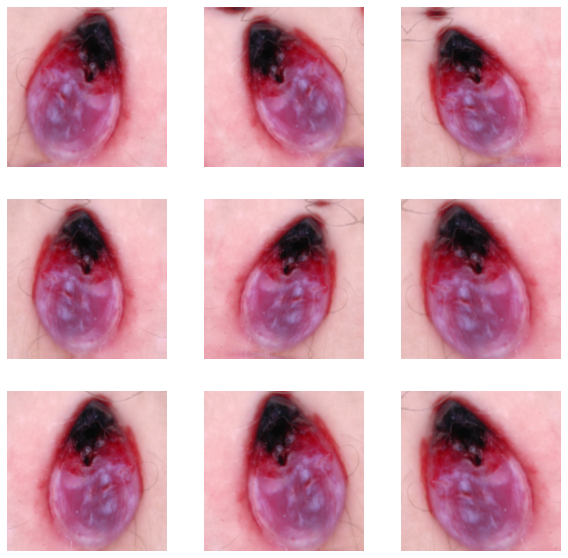

In [26]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [27]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## Your code goes here

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [28]:
## Your code goes here
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

### Training the model

In [29]:
## Your code goes here, note: train your model for 20 epochs
## your training code
history = model.fit(train_ds, validation_data=val_ds, epochs=20 )

Epoch 1/20
56/56 [==============================] - 3s 29ms/step - loss: 2.0426 - accuracy: 0.2612 - val_loss: 1.7142 - val_accuracy: 0.3960
Epoch 2/20
56/56 [==============================] - 1s 26ms/step - loss: 1.6333 - accuracy: 0.4230 - val_loss: 1.5207 - val_accuracy: 0.4810
Epoch 3/20
56/56 [==============================] - 1s 26ms/step - loss: 1.5376 - accuracy: 0.4665 - val_loss: 1.6063 - val_accuracy: 0.4049
Epoch 4/20
56/56 [==============================] - 1s 26ms/step - loss: 1.4881 - accuracy: 0.4766 - val_loss: 1.4833 - val_accuracy: 0.4832
Epoch 5/20
56/56 [==============================] - 1s 26ms/step - loss: 1.4371 - accuracy: 0.5000 - val_loss: 1.5150 - val_accuracy: 0.4743
Epoch 6/20
56/56 [==============================] - 1s 26ms/step - loss: 1.3697 - accuracy: 0.5167 - val_loss: 1.5295 - val_accuracy: 0.4877
Epoch 7/20
56/56 [==============================] - 1s 26ms/step - loss: 1.3302 - accuracy: 0.5234 - val_loss: 1.3689 - val_accuracy: 0.5324
Epoch 8/20
56

### Visualizing the results

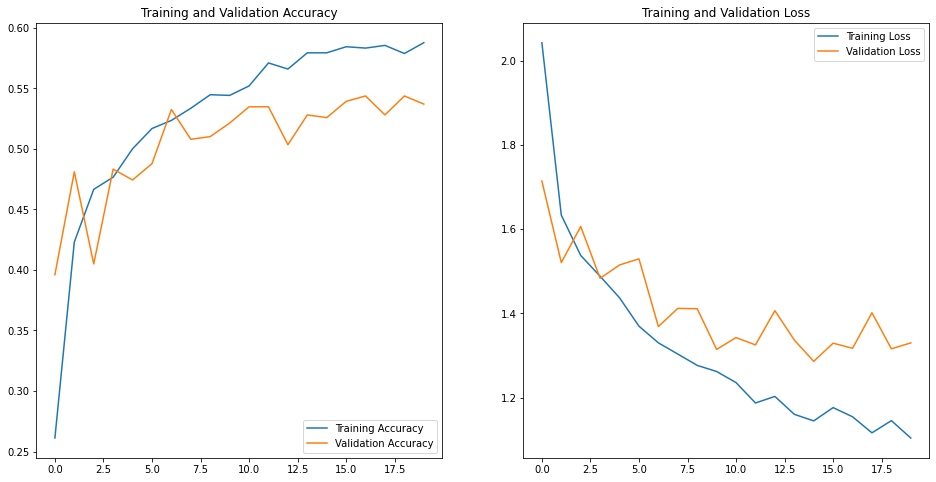

In [30]:
analyze_results(epochs, history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

In [31]:
accuracy_df = accuracy_df.append([{"Type":"Model - Extra data","Epochs":epochs,"Loss":history.history['loss'][-1],"Accuracy":history.history['accuracy'][-1],
                                  "Validation Loss":history.history['val_loss'][-1],"Validation Accuracy":history.history['val_accuracy'][-1]}])
accuracy_df

,Type,Epochs,Loss,Accuracy,Validation Loss,Validation Accuracy
0,Model - First,20,0.315078,0.881696,2.663557,0.521253
0,Model - Extra data,20,1.104220,0.587612,1.330113,0.536913


#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [32]:
## Your code goes here.
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/AI-ML/CNN_assignment/T...,actinic keratosis
1,/content/gdrive/MyDrive/AI-ML/CNN_assignment/T...,actinic keratosis
2,/content/gdrive/MyDrive/AI-ML/CNN_assignment/T...,actinic keratosis
3,/content/gdrive/MyDrive/AI-ML/CNN_assignment/T...,actinic keratosis
4,/content/gdrive/MyDrive/AI-ML/CNN_assignment/T...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/AI-ML/CNN_assignment/T...,basal cell carcinoma
2235,/content/gdrive/MyDrive/AI-ML/CNN_assignment/T...,basal cell carcinoma
2236,/content/gdrive/MyDrive/AI-ML/CNN_assignment/T...,basal cell carcinoma
2237,/content/gdrive/MyDrive/AI-ML/CNN_assignment/T...,basal cell carcinoma


In [33]:
# taking the complete training dtaa folder as source dataset
source_ds = image_dataset_from_directory(data_dir_train)
class_distr={}
for image_batch, labels_batch in source_ds:
    for i in range(image_batch.shape[0]):
      if class_names[labels_batch[i]] in class_distr:
        class_distr[class_names[labels_batch[i]]]+=1
      else:
        class_distr[class_names[labels_batch[i]]]=1
df_sample_distr = pd.DataFrame({"Class Name":class_distr.keys(), "Samples":class_distr.values()})
df_sample_distr.sort_values('Samples',ascending=False)

Found 2239 files belonging to 9 classes.


,Class Name,Samples
4,pigmented benign keratosis,462
1,melanoma,438
0,basal cell carcinoma,376
2,nevus,357
7,squamous cell carcinoma,181
8,vascular lesion,139
5,actinic keratosis,114
3,dermatofibroma,95
6,seborrheic keratosis,77


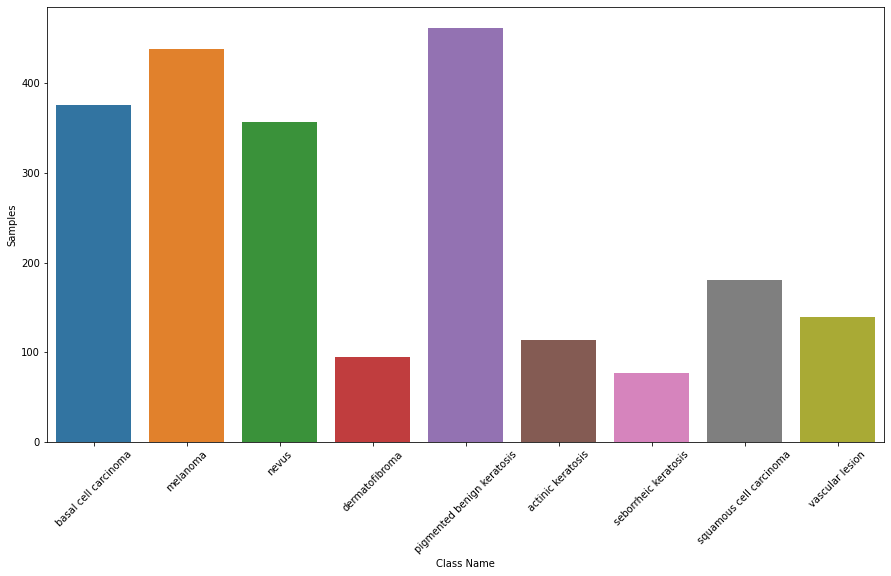

In [34]:
import seaborn as sns
plt.figure(figsize=(15, 8))
sns.barplot(data=df_sample_distr,x='Class Name',y='Samples')
plt.xticks(rotation = 45) 
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


# Observations:
* Class imbalance found in the trainign dataset
* Melanoma has maximum number of samples (462, 20.63%) whereas nevus has least number of samples.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [35]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [36]:
path_to_training_dataset="/content/gdrive/MyDrive/AI-ML/CNN_assignment/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI-ML/CNN_assignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7F24109E50>: 100%|██████████| 500/500 [00:19<00:00, 25.89 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI-ML/CNN_assignment/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7F266F35D0>: 100%|██████████| 500/500 [00:20<00:00, 24.00 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI-ML/CNN_assignment/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F804461CF50>: 100%|██████████| 500/500 [00:20<00:00, 23.92 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI-ML/CNN_assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F7F2648AF90>: 100%|██████████| 500/500 [01:25<00:00,  5.83 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI-ML/CNN_assignment/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F7F240F6350>: 100%|██████████| 500/500 [01:28<00:00,  5.63 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI-ML/CNN_assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7F240F1610>: 100%|██████████| 500/500 [00:18<00:00, 27.37 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI-ML/CNN_assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F7F26791810>: 100%|██████████| 500/500 [00:41<00:00, 12.08 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI-ML/CNN_assignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7F2648AE10>: 100%|██████████| 500/500 [00:17<00:00, 28.50 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI-ML/CNN_assignment/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7F240DA350>: 100%|██████████| 500/500 [00:17<00:00, 27.79 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [37]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [38]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list[:10]  ## printing 10

['/content/gdrive/MyDrive/AI-ML/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031292.jpg_14b4b4a9-958a-4c94-b16c-d468be0b8699.jpg',
 '/content/gdrive/MyDrive/AI-ML/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026848.jpg_ae7a790c-17bc-447a-9be3-40639ce4a88c.jpg',
 '/content/gdrive/MyDrive/AI-ML/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030825.jpg_259c6bf1-386b-47a4-aa65-928c24838f15.jpg',
 '/content/gdrive/MyDrive/AI-ML/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026626.jpg_8b79e76c-45f8-4214-b936-5749264a1c7a.jpg',
 '/content/gdrive/MyDrive/AI-ML/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027562.jpg_b9127b64-8147-4244-91a6-dfe7f163baa3.jpg',
 '/content/gdrive/MyDrive/AI-ML/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033866.jpg_d7069c95-7d9f-4c08-a435-64cdbc7167e6.jpg',
 '/content

In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:10]  ## printing 10

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [40]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [41]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [42]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [43]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [44]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/AI-ML/CNN_assignment/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [45]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [46]:
## your code goes here
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# model = Sequential([
#   layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes)
# ])

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [47]:
## your code goes here
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

#### **Todo:**  Train your model

In [48]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 41s 66ms/step - loss: 2.0137 - accuracy: 0.2431 - val_loss: 1.6458 - val_accuracy: 0.3727
Epoch 2/50
169/169 [==============================] - 4s 23ms/step - loss: 1.4927 - accuracy: 0.4416 - val_loss: 1.3408 - val_accuracy: 0.4996
Epoch 3/50
169/169 [==============================] - 4s 23ms/step - loss: 1.2730 - accuracy: 0.5208 - val_loss: 1.2008 - val_accuracy: 0.5427
Epoch 4/50
169/169 [==============================] - 4s 23ms/step - loss: 1.0949 - accuracy: 0.6035 - val_loss: 1.0425 - val_accuracy: 0.6147
Epoch 5/50
169/169 [==============================] - 4s 23ms/step - loss: 0.9177 - accuracy: 0.6691 - val_loss: 0.8686 - val_accuracy: 0.6748
Epoch 6/50
169/169 [==============================] - 4s 23ms/step - loss: 0.7644 - accuracy: 0.7235 - val_loss: 1.0363 - val_accuracy: 0.6347
Epoch 7/50
169/169 [==============================] - 4s 23ms/step - loss: 0.6943 - accuracy: 0.7548 - val_loss: 0.7544 - val_accuracy: 0.725

#### **Todo:**  Visualize the model results

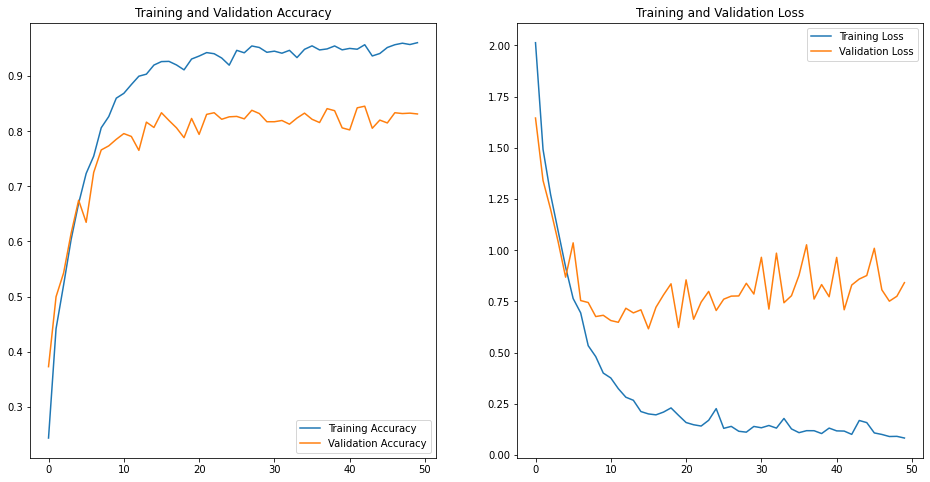

In [49]:
analyze_results(epochs, history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [50]:
# analyzing Last Epochs of each Model
accuracy_df = accuracy_df.append([{"Type":"Model - Class rebalance","Epochs":epochs,"Loss":history.history['loss'][-1],"Accuracy":history.history['accuracy'][-1],
                                  "Validation Loss":history.history['val_loss'][-1],"Validation Accuracy":history.history['val_accuracy'][-1]}])
accuracy_df

,Type,Epochs,Loss,Accuracy,Validation Loss,Validation Accuracy
0,Model - First,20,0.315078,0.881696,2.663557,0.521253
0,Model - Extra data,20,1.104220,0.587612,1.330113,0.536913
0,Model - Class rebalance,50,0.083136,0.960868,0.841888,0.831477


# Obeservations:
* Validation accuracy **appx 80%**.
* Model accuracy **appx 95%**.
* Though the model accuracy has improved, the class rebalancing has help in treating the overfitting.
* We can use this model with class rebalance for prediction.
